# With Valid Stocks and 2 years of data, Sector Utilities

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from mymodule.DatabaseConnection import CRUD
from dotenv import load_dotenv
load_dotenv()
 
from sklearn.preprocessing import LabelEncoder

In [5]:
lo_stock = CRUD('v_stockdailyupdate')
df_stocks = lo_stock.Read()
df_stocks.dropna(subset=['SectorId'],inplace=True)
df_stocks = df_stocks[df_stocks['BlackListed'].isna()]
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

df_stocks = df_stocks.sort_values('Date')

df_stocks = df_stocks[df_stocks['Date'] >= '20231201']
df_stocks = df_stocks[df_stocks['Date'] < '20251201']

DataBase Disconnected


In [6]:
df_count = pd.DataFrame(data=df_stocks[df_stocks['Date'] >= '20231201']['ISIN'].value_counts().reset_index())
df_count.columns = ['ISIN', 'COUNT']
df_valid = df_count[df_count['COUNT']==493]
df_stocks = df_stocks.merge(df_valid, how='inner', on='ISIN')

df_stocks = df_stocks.sort_values(by=['ISIN','Date']).reset_index()
df_stocks = df_stocks[['Date','ISIN','SectorId','open','high','low','close','volume']]

In [7]:
df_stocks['SectorId'] = df_stocks['SectorId'].astype('int')

In [8]:
df_stocks['ISIN'].value_counts()

ISIN
IN9175A01010    493
IN9623B01058    493
INE001B01026    493
INE002A01018    493
INE002L01015    493
               ... 
INE998H01012    493
INE998I01010    493
INE999A01023    493
INE999B01013    493
INE999K01014    493
Name: count, Length: 1813, dtype: int64

In [10]:
features = ['open', 'high', 'low', 'close', 'volume' ]

#for sector in sectors:
df_stocks1 = df_stocks[df_stocks['SectorId'] == 11 ]
df_stocks1.reset_index(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_stocks1[features])

le = LabelEncoder()
ISIN = le.fit_transform(df_stocks1['ISIN'])

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_stocks1.index)
scaled_df['ISIN'] = ISIN

In [11]:
lookback = 60
X, y = [], []
for a in range(scaled_df['ISIN'].nunique()):
    print('Stock : ',a+1)
    scaled_df1 = scaled_df[a*493:(a+1)*493]
    scaled_df1.reset_index(inplace=True)
    scaled_df1 = scaled_df1.drop(columns=['index'],axis=1)
    for i in range(lookback, len(scaled_df1)):
        X.append(scaled_df1.iloc[i-lookback:i].values)
        y.append(scaled_df1.iloc[i]['close'])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # (samples, timesteps=60, features)
print("y shape:", y.shape)  # (samples,)

Stock :  1
Stock :  2
Stock :  3
Stock :  4
Stock :  5
Stock :  6
Stock :  7
Stock :  8
Stock :  9
Stock :  10
Stock :  11
Stock :  12
Stock :  13
Stock :  14
Stock :  15
Stock :  16
Stock :  17
Stock :  18
Stock :  19
Stock :  20
Stock :  21
Stock :  22
Stock :  23
Stock :  24
Stock :  25
Stock :  26
Stock :  27
Stock :  28
Stock :  29
Stock :  30
Stock :  31
Stock :  32
Stock :  33
X shape: (14289, 60, 6)
y shape: (14289,)


In [12]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [13]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output (predicting next-day price)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Projects\Market\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0092 - val_loss: 9.5763e-04
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0019 - val_loss: 3.5196e-04
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0014 - val_loss: 4.4361e-04
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0010 - val_loss: 4.7555e-04
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 9.2166e-04 - val_loss: 3.4274e-04
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 8.4642e-04 - val_loss: 4.6437e-04
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 7.2611e-04 - val_loss: 5.1609e-05
Epoch 8/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 7.1800e-04 - val_loss: 2.2478e-04
Epoch 9/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 6.3437e-04 - val_loss: 1.5856e-04
Epoch 10/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 5.7909e-04 - val_loss: 6.6503e-05
Epoch 11/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 32m

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


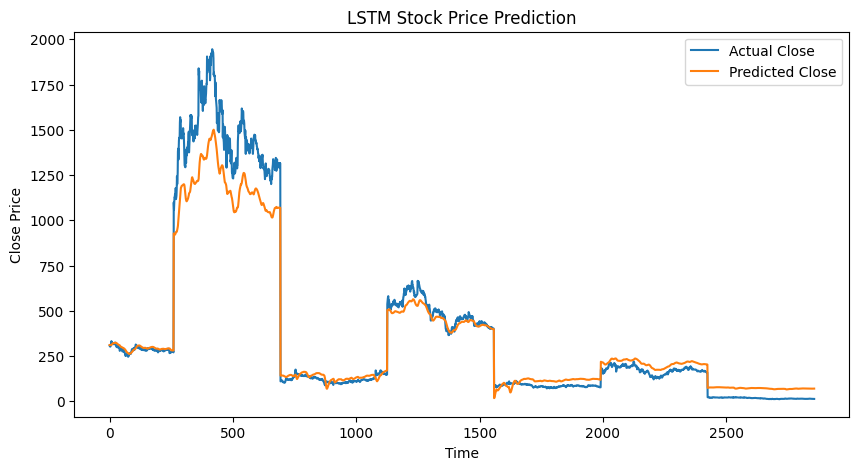

In [15]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 13956.3000
RMSE: 118.1368
MAE : 69.6904
R²  : 0.9407
